# Evaluation of XGBoost GEDI -> S1S2 Regression Model

Having successfully ingested GEDI L4A and collocated Sentinel statistical data into a spatiotemporal database, energies now focussed on training a random model regressor to predict wall-to-wall maps of GEDI-estimated Aboveground Biomass Density. Using the functional firepower of PostgreSQL and PostGIS, aggregated subsets of collocated GEDI and Sentinel-based metrics were extracted from the spatiotemporal database as a source of training and test data. 

__Important Note:__ Statistics related to [S2 cloudless mask](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/) were retrieved from Sentinel-Hub and ingested into the Sentinel-2 data tables - records were therefore filtered based on presence of cloud contamination affecting multispectral statistic calculations.

### Load and filter GEDI + Sentinel SAR and multispectral metrics from CSV file

In [1]:
import pandas as pd

# load sql dump dataset
df = pd.read_csv("result_update.csv" )
df.columns

Index(['shot_number', 'datetime', 'ndvi_mean', 'ndvi_stdev', 'evi_mean',
       'evi_stdev', 'gndvi_mean', 'gndvi_stdev', 'ndci_mean', 'ndci_stdev',
       'mcari_mean', 'mcari_stdev', 'lai_mean', 'lai_stdev', 'fapar_mean',
       'fapar_stdev', 'fcover_mean', 'fcover_stdev', 'ccc_mean', 'ccc_stdev',
       'cab_mean', 'cab_stdev', 'vv_mean', 'vv_stdev', 'vh_mean', 'vh_stdev',
       'rvi_mean', 'rvi_stdev', 'atsavi_mean', 'atsavi_stdev', 'avi_mean',
       'avi_stdev', 'bwdrvi_mean', 'bwdrvi_stdev', 'cari_mean', 'cari_stdev',
       'ctvi_mean', 'ctvi_stdev', 'gemi_mean', 'gemi_stdev', 'lci_mean',
       'lci_stdev', 'mcari_osavi_mean', 'mcari_osavi_stdev', 'msavi_mean',
       'msavi_stdev', 'mtvi2_mean', 'mtvi2_stdev', 'pndvi_mean', 'pndvi_stdev',
       'pvi_mean', 'pvi_stdev', 'rsr_stdev', 'reip1_mean', 'reip1_stdev',
       'sarvi_mean', 'sarvi_stdev', 'savi_mean', 'savi_stdev', 'nsimss_mean',
       'nsimss_stdev', 'gvi_mean', 'gvi_stdev', 'tcari_mean', 'tcari_stdev',
       'tn

In [2]:
# filter out high value agbd outliers
names = [ col for col in df.columns if 'stdev' in col or 'mean' in col ]
names.extend( [ 'landsat_treecover', 'agbd', 'geometry' ] )

df = df[ names ]
df = df[ ~df.isnull().any(axis=1)]
df = df[ df[ 'agbd'] < 300  ]

### Transpose into GeoDataFrame in preparation for spatial aggregation

In [3]:
import geopandas as gpd
from shapely import wkb

# convert wkb geometries into shapely point objects in geographic crs
df['geometry'] = df['geometry'].apply( wkb.loads, hex=True )
gdf = gpd.GeoDataFrame( df, geometry='geometry', crs='epsg:4326' )

In [4]:
# code to append srtm height to dataframe - analysis revealed minimal correlation with agbd

"""
from pathlib import Path
from srtm import Srtm1HeightMapCollection

# create srtm reader object
obj = Srtm1HeightMapCollection()
obj.hgt_dir = Path( 'C:\\Users\\crwil\\Documents\\data\\srtm' )
obj.build_file_index()

# derive srtm height for all locations
elevation = list()
for row in gdf.itertuples():    
    
    if row.geometry is not None:
        elevation.append( obj.get_altitude( latitude=row.geometry.y, longitude=row.geometry.x ) )

# add new column to dataframe
gdf.insert( 0, 'elevation', elevation )
"""

gdf.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tndvi_stdev,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover,agbd,geometry
0,0.291376,0.015606,0.165770,0.011002,0.388302,0.010073,0.131362,0.011447,0.029094,0.004091,...,0.008730,41.610693,146.695745,0.028822,0.003819,0.131362,0.011447,9,6.651023,POINT (36.23599 -0.53326)
1,0.269227,0.034365,0.148565,0.021000,0.427946,0.024159,0.117192,0.018679,0.022538,0.006509,...,0.019463,11.474940,141.338519,0.019826,0.006483,0.117192,0.018679,6,31.625132,POINT (36.26564 -0.57539)
2,0.690576,0.094037,0.351772,0.097142,0.657159,0.062445,0.354357,0.119054,0.083775,0.047492,...,0.044482,8.774529,33.826583,0.058347,0.026993,0.354357,0.119054,20,294.035828,POINT (36.67005 -1.14952)
3,0.640556,0.070545,0.419729,0.071231,0.606387,0.053391,0.300911,0.058271,0.079783,0.024884,...,0.033572,5.767614,5.818297,0.066356,0.015647,0.300911,0.058271,27,115.615028,POINT (36.69320 -1.18238)
4,0.579399,0.094203,0.404494,0.094958,0.570705,0.054946,0.259774,0.071382,0.076620,0.031332,...,0.045505,12.087484,53.658756,0.064929,0.021825,0.259774,0.071382,16,12.274698,POINT (36.71104 -1.20765)


In [5]:
gdf.total_bounds, len( gdf )

(array([35.41428939, -1.30904186, 37.39445352,  0.86672992]), 351866)

In [6]:
# subset - optional - and reproject to pseudo mercator
gdf = gdf.cx[ 35.5:37.2, -1.2:0.5 ]
gdf = gdf.to_crs( 3857 )
gdf

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tndvi_stdev,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover,agbd,geometry
0,0.291376,0.015606,0.165770,0.011002,0.388302,0.010073,0.131362,0.011447,0.029094,0.004091,...,0.008730,41.610693,146.695745,0.028822,0.003819,0.131362,0.011447,9,6.651023,POINT (4033772.391 -59362.853)
1,0.269227,0.034365,0.148565,0.021000,0.427946,0.024159,0.117192,0.018679,0.022538,0.006509,...,0.019463,11.474940,141.338519,0.019826,0.006483,0.117192,0.018679,6,31.625132,POINT (4037072.377 -64053.317)
2,0.690576,0.094037,0.351772,0.097142,0.657159,0.062445,0.354357,0.119054,0.083775,0.047492,...,0.044482,8.774529,33.826583,0.058347,0.026993,0.354357,0.119054,20,294.035828,POINT (4082091.053 -127972.218)
3,0.640556,0.070545,0.419729,0.071231,0.606387,0.053391,0.300911,0.058271,0.079783,0.024884,...,0.033572,5.767614,5.818297,0.066356,0.015647,0.300911,0.058271,27,115.615028,POINT (4084668.874 -131631.153)
7,0.379653,0.058794,0.221880,0.040194,0.417894,0.044949,0.154614,0.038600,0.036796,0.013031,...,0.031140,3.661067,35.591905,0.037394,0.010657,0.154614,0.038600,5,11.673766,POINT (4064490.074 -103985.182)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365560,0.786000,0.016111,0.456203,0.038255,0.676739,0.017522,0.439879,0.025886,0.110545,0.015392,...,0.007121,3.454784,0.329519,0.080529,0.008001,0.439879,0.025886,90,126.382660,POINT (4068374.252 -10701.657)
365561,0.726764,0.034848,0.304002,0.034822,0.642763,0.034058,0.386903,0.041403,0.064315,0.013022,...,0.015708,2.566765,0.171601,0.049355,0.006349,0.386903,0.041403,54,42.364956,POINT (4126163.552 -8588.928)
365562,0.649938,0.044124,0.470920,0.051203,0.562877,0.029201,0.319895,0.043381,0.099366,0.020672,...,0.020680,12.528541,18.023661,0.087420,0.013332,0.319895,0.043381,12,10.447485,POINT (4075498.847 -79029.986)
365563,0.522598,0.109225,0.313020,0.087792,0.549610,0.085997,0.213298,0.076354,0.051133,0.026145,...,0.055162,17.288423,79.728946,0.044869,0.019182,0.213298,0.076354,12,21.331646,POINT (4080180.956 -123699.185)


<AxesSubplot:ylabel='Frequency'>

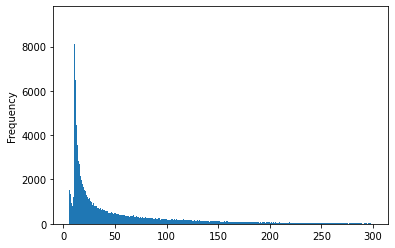

In [7]:
# plot agbd distribution
gdf[ 'agbd' ].plot.hist(bins=1000)

### Generate regular grid encapsulating extent of GEDI / Sentinel sample data

In [8]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf.total_bounds
gdf.total_bounds

array([3951842.43185071, -133593.01774117, 4141084.99071914,
         55659.88000611])

In [9]:
import numpy as np
import shapely

cell_size = 200

# generate grid of nominated cell size in metres
cells = []
for x0 in np.arange( xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange( ymin, ymax+cell_size, cell_size):
        
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        
        cells.append( shapely.geometry.box(x0, y0, x1, y1) )        

In [10]:
# create dataframe comprising grid cell polygons
grid = gpd.GeoDataFrame( cells, crs='epsg:3857', columns=['geometry'] )
grid.head(5)

,geometry
0,"POLYGON ((3951642.432 -133593.018, 3951642.432..."
1,"POLYGON ((3951642.432 -133393.018, 3951642.432..."
2,"POLYGON ((3951642.432 -133193.018, 3951642.432..."
3,"POLYGON ((3951642.432 -132993.018, 3951642.432..."
4,"POLYGON ((3951642.432 -132793.018, 3951642.432..."


### Visualise grid superimposed over colour-coded GEDI-based AGBD estimates

(-41793.01774117078, -35793.01774117078)

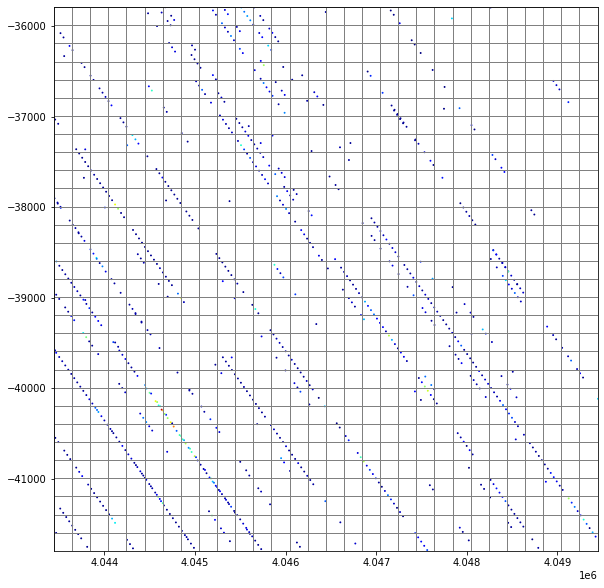

In [11]:
import matplotlib.pyplot as plt

# plot points overlaid by grid
ax = gdf.plot(markersize=.8, figsize=(20, 10), column='agbd', cmap='jet')
plt.autoscale(False)
grid.plot(ax=ax, aspect=1, facecolor="none", edgecolor='grey')

xc, yc = grid.dissolve().centroid.x.values[0], grid.dissolve().centroid.y.values[0]

plt.xlim( [ xc - 3000, xc + 3000 ] )
plt.ylim( [ yc - 3000, yc + 3000 ] )

### Compute spatially aggregated GEDI-Sentinel parameter values within each grid cell 

In [12]:
# merge dataframes to assign GEDI-Sentinel point geometries to corresponding grid cell
merge = gpd.sjoin( gdf, grid, how='left', predicate='within' )
merge.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover,agbd,geometry,index_right
0,0.291376,0.015606,0.165770,0.011002,0.388302,0.010073,0.131362,0.011447,0.029094,0.004091,...,41.610693,146.695745,0.028822,0.003819,0.131362,0.011447,9,6.651023,POINT (4033772.391 -59362.853),389051.0
1,0.269227,0.034365,0.148565,0.021000,0.427946,0.024159,0.117192,0.018679,0.022538,0.006509,...,11.474940,141.338519,0.019826,0.006483,0.117192,0.018679,6,31.625132,POINT (4037072.377 -64053.317),405143.0
2,0.690576,0.094037,0.351772,0.097142,0.657159,0.062445,0.354357,0.119054,0.083775,0.047492,...,8.774529,33.826583,0.058347,0.026993,0.354357,0.119054,20,294.035828,POINT (4082091.053 -127972.218),618124.0
3,0.640556,0.070545,0.419729,0.071231,0.606387,0.053391,0.300911,0.058271,0.079783,0.024884,...,5.767614,5.818297,0.066356,0.015647,0.300911,0.058271,27,115.615028,POINT (4084668.874 -131631.153),630429.0
7,0.379653,0.058794,0.221880,0.040194,0.417894,0.044949,0.154614,0.038600,0.036796,0.013031,...,3.661067,35.591905,0.037394,0.010657,0.154614,0.038600,5,11.673766,POINT (4064490.074 -103985.182),534820.0


In [13]:
# compute median GEDI-Sentinel point by dissolving on spatial join index
agg = merge.dissolve(by="index_right", aggfunc='median')
agg.head(5)

,geometry,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,...,tndvi_mean,tndvi_stdev,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover,agbd
index_right,,,,,,,,,,,,,,,,,,,,,
1370.0,POINT (3952013.966 -49011.485),0.732401,0.042833,0.483461,0.076493,0.647912,0.025343,0.389534,0.045628,0.114276,...,1.109949,0.019648,74.981174,414.619223,0.088175,0.016138,0.389534,0.045628,29.0,44.551723
1371.0,"MULTIPOINT (3951882.458 -48824.445, 3951915.82...",0.639945,0.088176,0.391542,0.074966,0.603746,0.044635,0.327293,0.064236,0.089241,...,1.066859,0.041310,5.577071,13.411982,0.071412,0.017546,0.327293,0.064236,44.0,15.772111
1372.0,"MULTIPOINT (3951849.142 -48777.047, 3951903.66...",0.622995,0.060999,0.404987,0.065067,0.602612,0.029462,0.301855,0.040795,0.085896,...,1.057541,0.030289,6.238382,52.872384,0.069555,0.012680,0.301855,0.040795,24.5,25.621703
1376.0,"MULTIPOINT (3951862.734 -47901.157, 3951885.09...",0.702949,0.053052,0.431515,0.064996,0.613408,0.045860,0.343919,0.059523,0.087548,...,1.096409,0.024177,3.336166,26.469644,0.070648,0.014427,0.343919,0.059523,29.0,17.879596
1377.0,"MULTIPOINT (3951850.659 -47659.717, 3951852.89...",0.606588,0.073826,0.349302,0.072531,0.597020,0.047777,0.264897,0.057395,0.066202,...,1.050736,0.037903,7.936557,57.613317,0.058713,0.016157,0.264897,0.057395,18.0,13.331037


In [14]:
# compute number of GEDI-Sentinel points per grid cell by dissolving on spatial join index
count = merge.dissolve( by="index_right", aggfunc='count')
count.head(5)

,geometry,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,...,tndvi_mean,tndvi_stdev,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover,agbd
index_right,,,,,,,,,,,,,,,,,,,,,
1370.0,POINT (3952013.966 -49011.485),1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1371.0,"MULTIPOINT (3951882.458 -48824.445, 3951915.82...",5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1372.0,"MULTIPOINT (3951849.142 -48777.047, 3951903.66...",2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1376.0,"MULTIPOINT (3951862.734 -47901.157, 3951885.09...",8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
1377.0,"MULTIPOINT (3951850.659 -47659.717, 3951852.89...",6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [15]:
# combine median + count spatial aggregations
data = agg.copy().reset_index( drop=True).copy()
data[ 'count'] = count[ 'agbd' ].values 

# apply minimum count condition to sample data
data = data[ data[ 'count'] > 4 ].drop( [ 'count', 'geometry' ], axis=1 )
data

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tndvi_mean,tndvi_stdev,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover,agbd
1,0.639945,0.088176,0.391542,0.074966,0.603746,0.044635,0.327293,0.064236,0.089241,0.034439,...,1.066859,0.041310,5.577071,13.411982,0.071412,0.017546,0.327293,0.064236,44.0,15.772111
3,0.702949,0.053052,0.431515,0.064996,0.613408,0.045860,0.343919,0.059523,0.087548,0.023311,...,1.096409,0.024177,3.336166,26.469644,0.070648,0.014427,0.343919,0.059523,29.0,17.879596
4,0.606588,0.073826,0.349302,0.072531,0.597020,0.047777,0.264897,0.057395,0.066202,0.024174,...,1.050736,0.037903,7.936557,57.613317,0.058713,0.016157,0.264897,0.057395,18.0,13.331037
25,0.781368,0.052405,0.512329,0.078577,0.689436,0.029705,0.450410,0.066356,0.150057,0.045139,...,1.131726,0.023446,6.202000,17.053772,0.100193,0.022712,0.450410,0.066356,37.0,13.487969
44,0.596429,0.096541,0.368918,0.097028,0.586542,0.050529,0.273962,0.062051,0.070364,0.027657,...,1.045000,0.048293,7.110539,21.195339,0.055361,0.018662,0.273962,0.062051,20.0,18.872623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129433,0.781408,0.023957,0.448328,0.045695,0.690619,0.021126,0.443477,0.048097,0.112873,0.021341,...,1.131953,0.010494,3.659395,1.008727,0.077932,0.011127,0.443477,0.048097,72.0,122.144646
129440,0.761868,0.020795,0.417539,0.052706,0.664494,0.027251,0.423395,0.053937,0.103906,0.025570,...,1.123308,0.009207,3.421644,0.894373,0.073889,0.009934,0.423395,0.053937,54.0,163.115417
129444,0.745369,0.018822,0.486624,0.043908,0.608120,0.025740,0.436040,0.033023,0.139891,0.020683,...,1.115688,0.008470,-2.747825,140.206463,0.102226,0.012550,0.436040,0.033023,62.0,205.665939
129447,0.739955,0.024779,0.476134,0.048587,0.636382,0.035700,0.400742,0.038601,0.119225,0.022098,...,1.113386,0.011191,5.108044,2.539597,0.091190,0.010237,0.400742,0.038601,51.0,155.858582


### Visualise collinearity between spatially aggregated GEDI / Sentinel parameter values

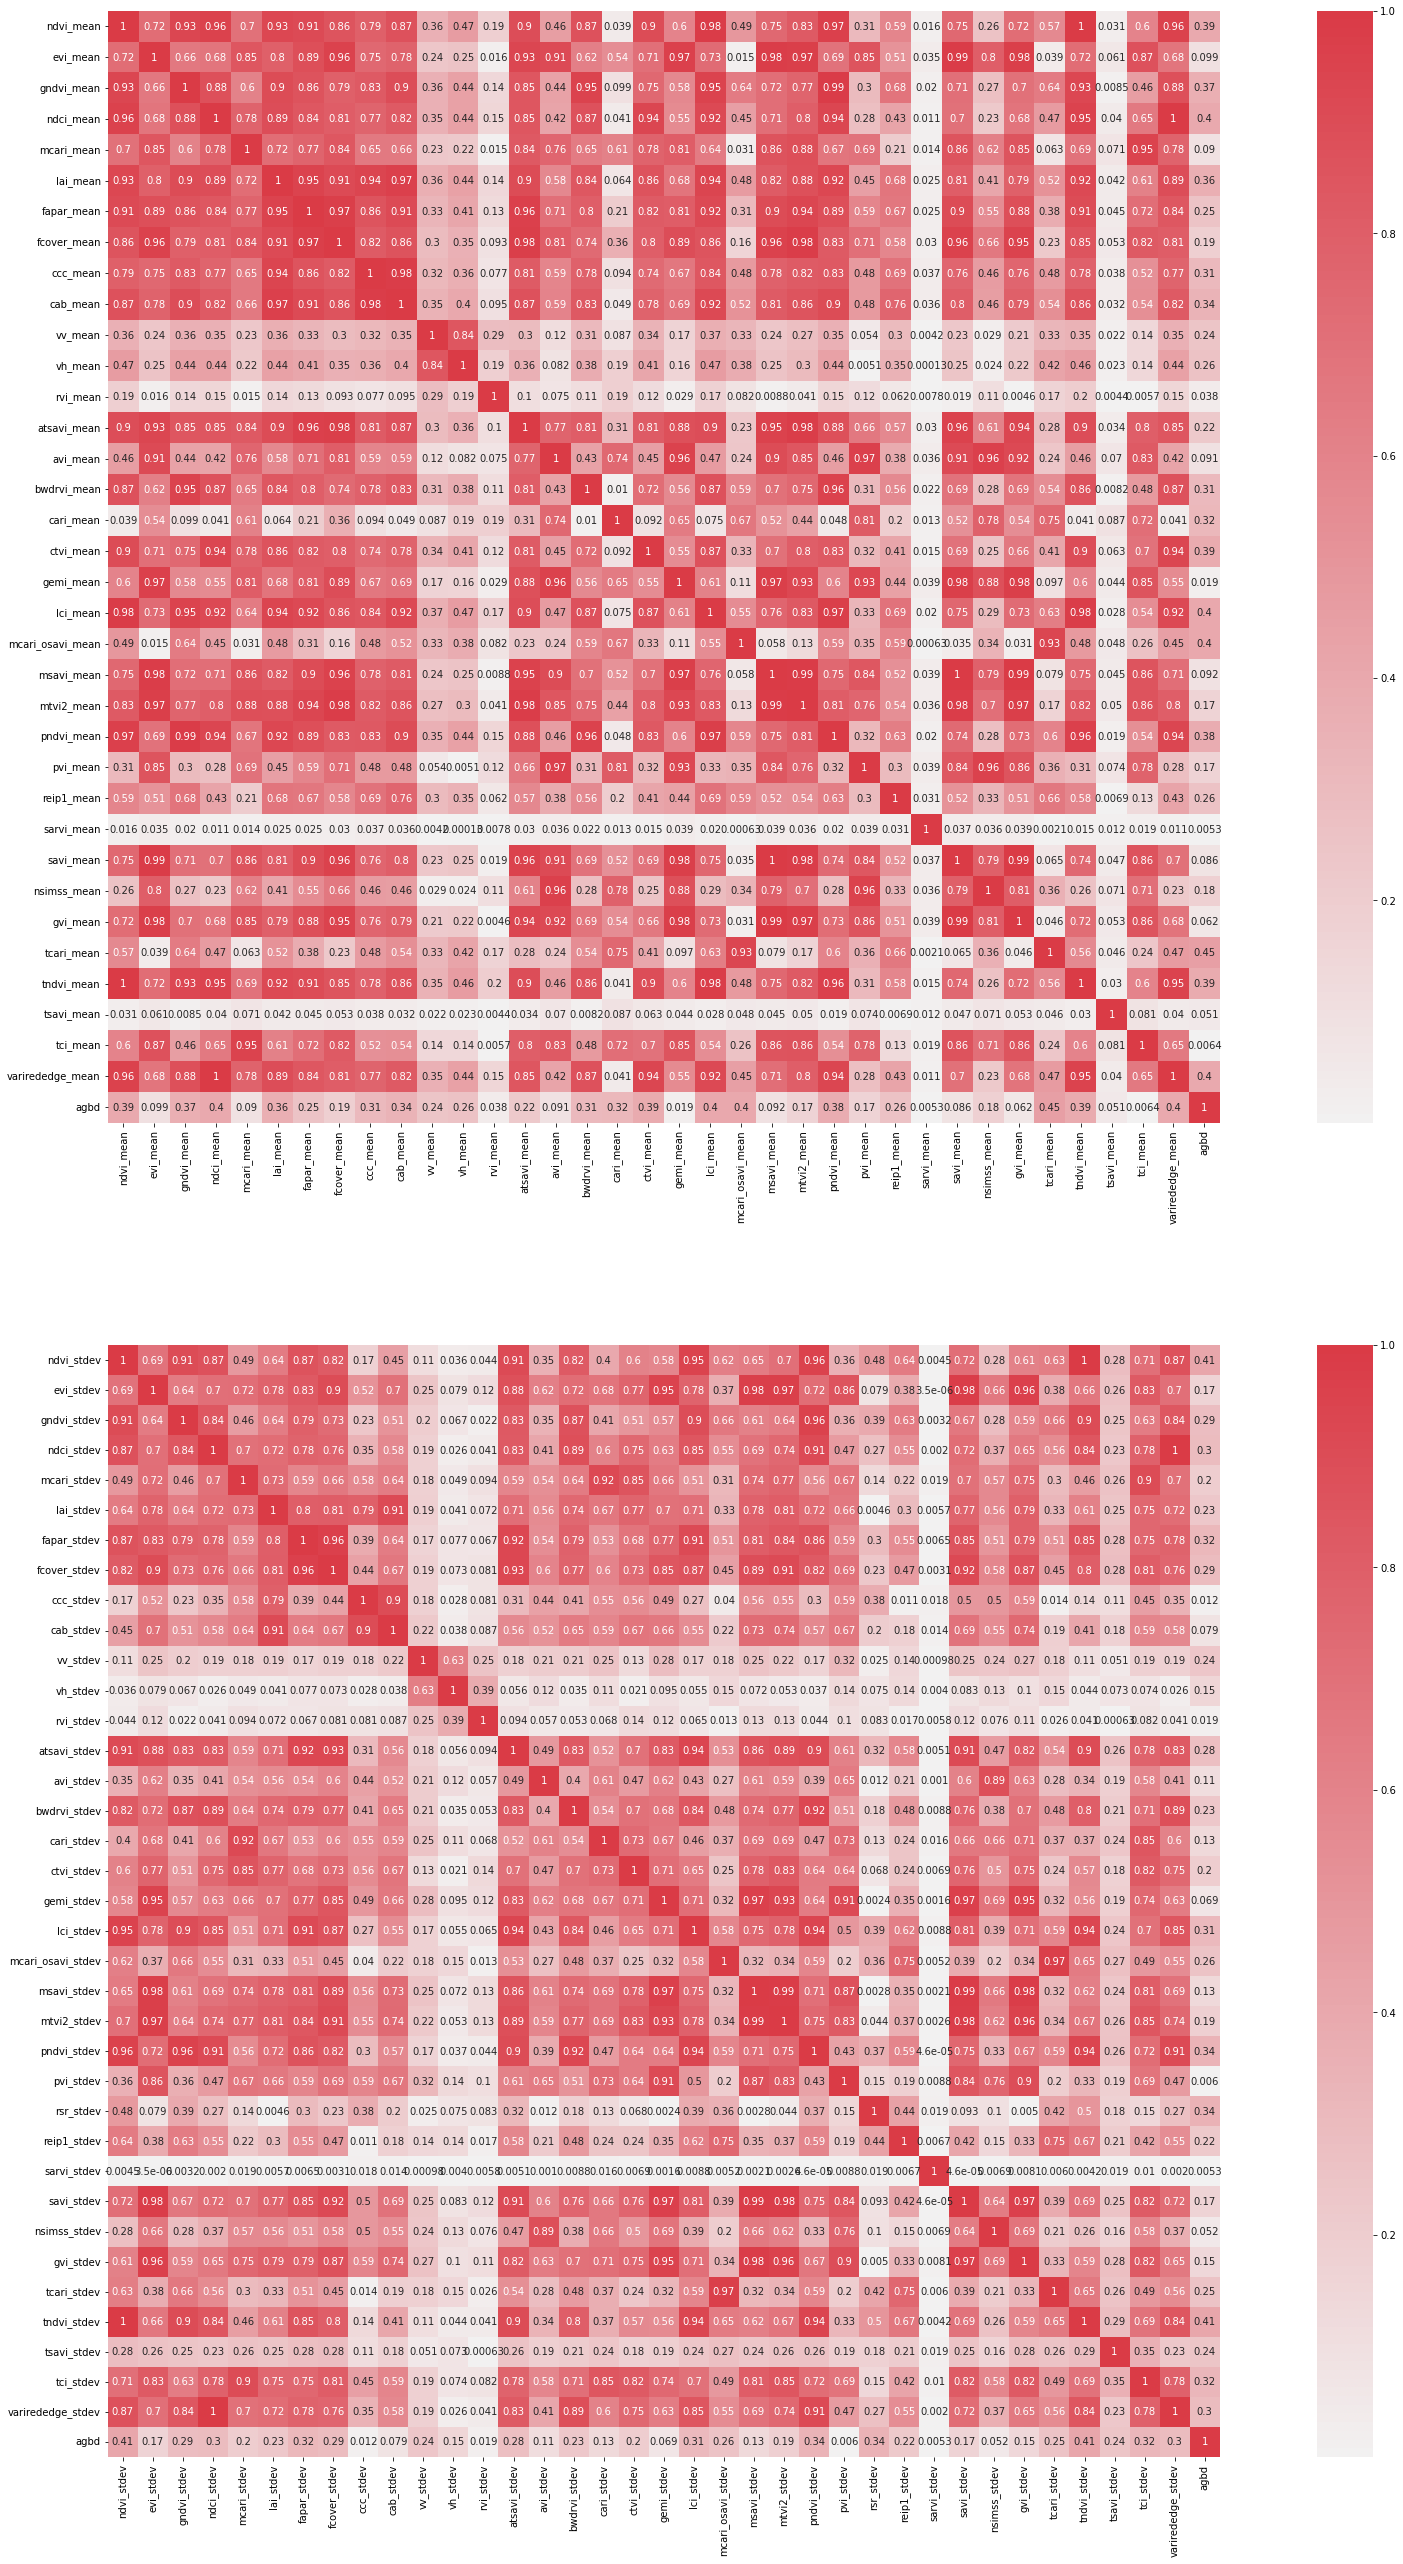

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotCorrelationHeatmap( ax, names, cmap ):

    names.extend( [ 'agbd' ] )
    sns.heatmap( data[ names ].corr().abs(), ax=ax, cmap=cmap, center=0, square=True, annot=True )

# plot correlation matrix
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(35,45) )
cmap = sns.diverging_palette( 500, 10, as_cmap=True )

plotCorrelationHeatmap( axes[ 0 ], [ col for col in data.columns if 'mean' in col ], cmap )
plotCorrelationHeatmap( axes[ 1 ], [ col for col in data.columns if 'stdev' in col ], cmap )

<AxesSubplot:>

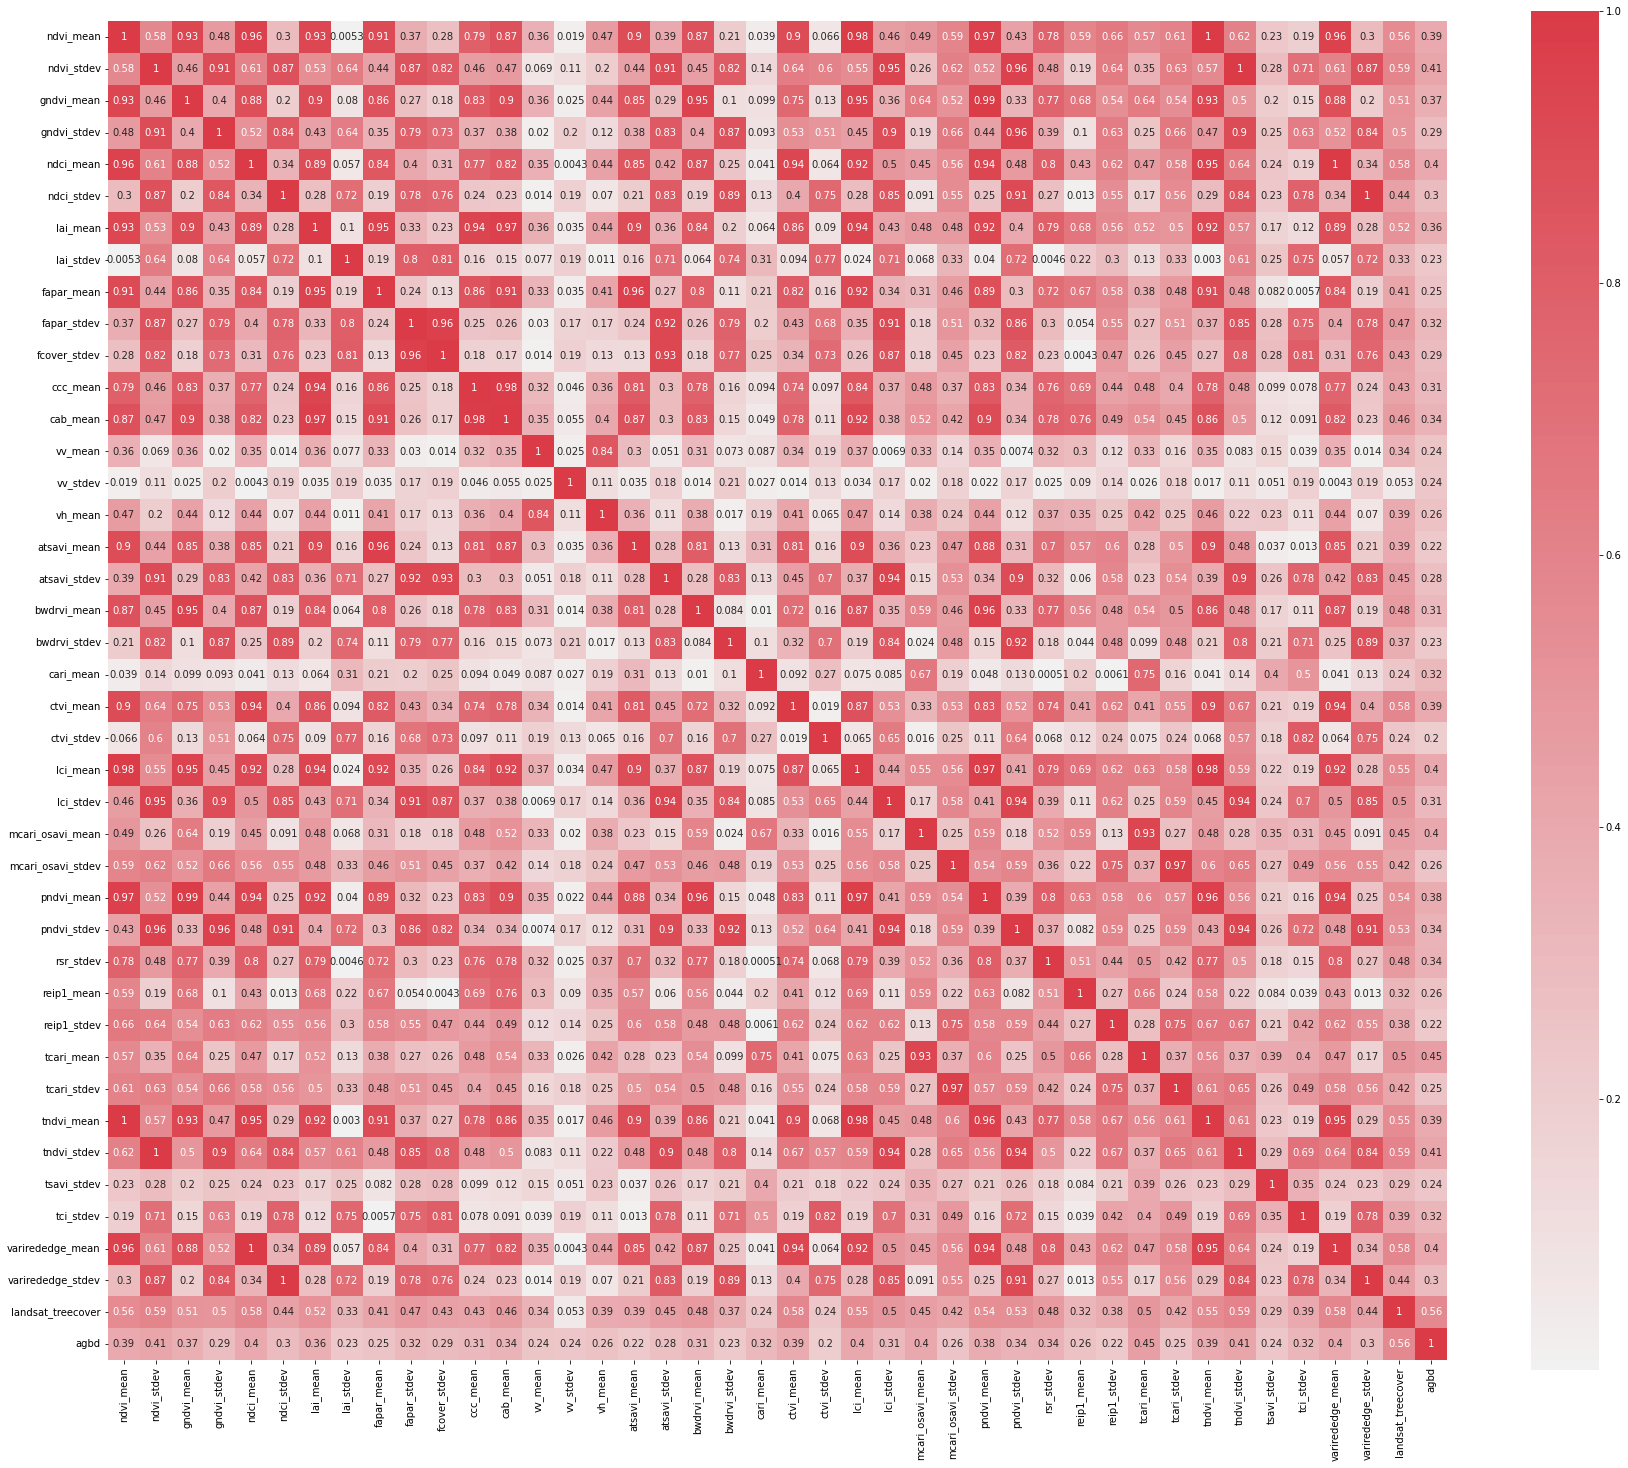

In [17]:
# plot correlation matrix
data = data[ data.columns[ data.corr().abs()[ 'agbd' ] > 0.2 ] ]
plt.figure( figsize=(30,25) )
sns.heatmap( data.corr().abs(), cmap=cmap, center=0, square=True, annot=True )

### Visualise distribution of Sentinel-1 and Sentinel-2 predictor variables

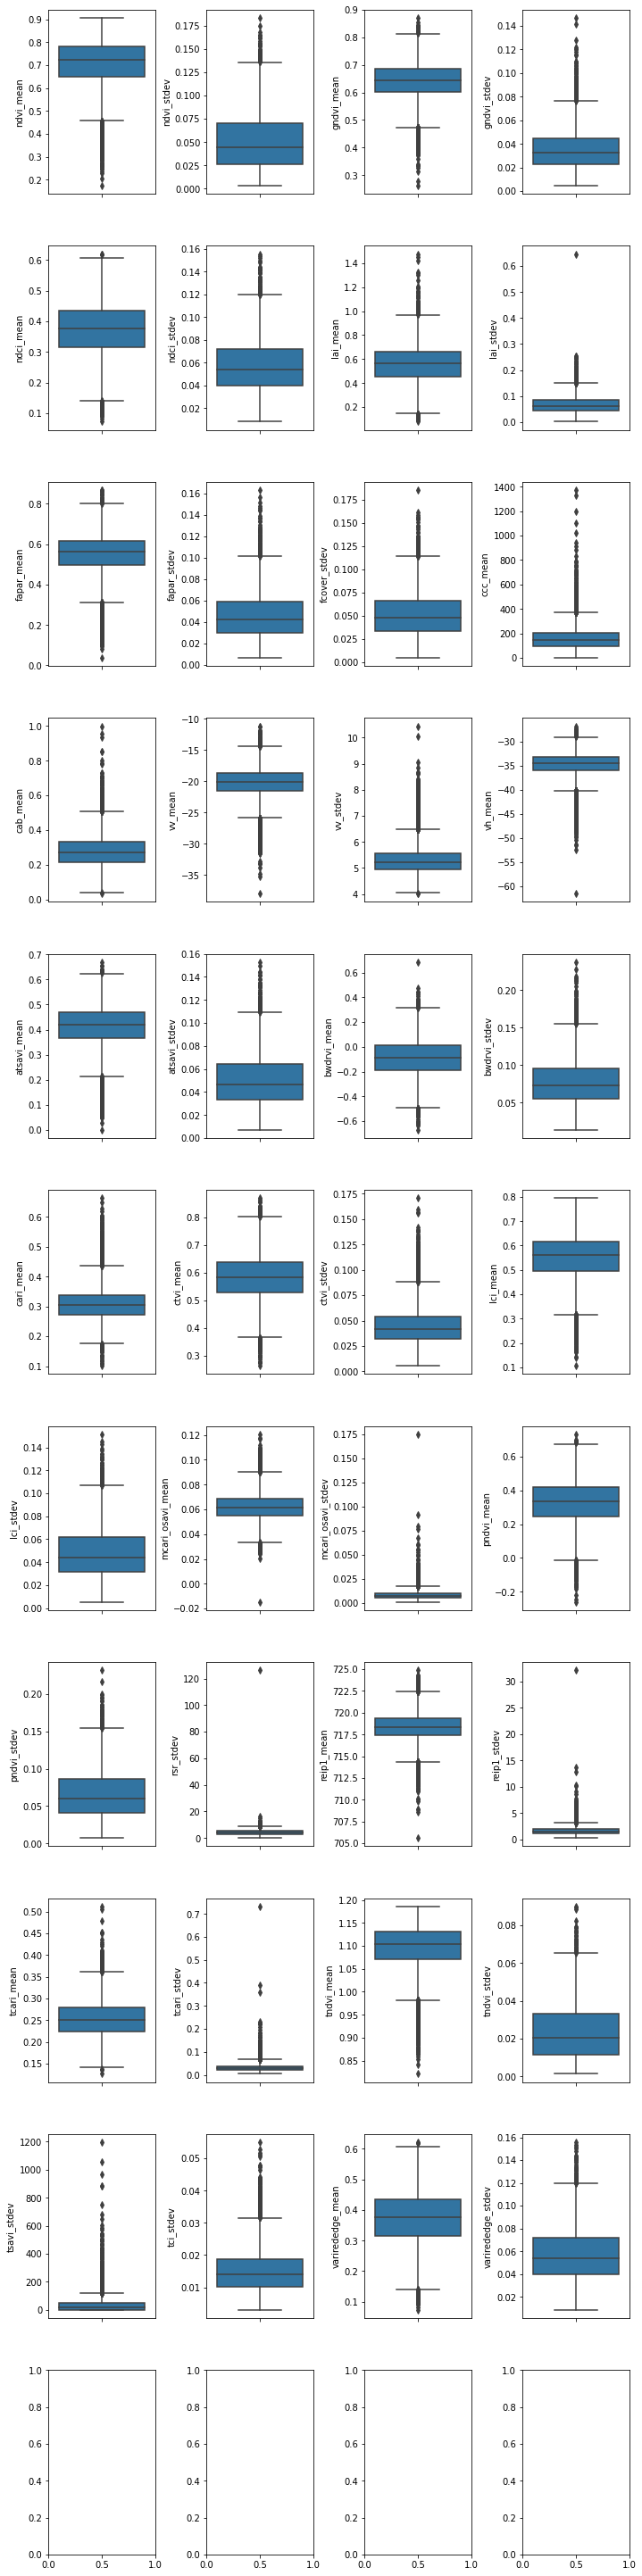

In [18]:
cols = [ col for col in data.columns if 'mean' in col or 'stdev' in col ]

# visualise feature variable distributions using boxplot diagrams
def getBoxPlots( df ):
        
    fig, axs = plt.subplots( ncols=4, nrows=int( len(cols)/4 ) + 1, figsize=(10,40))
    index = 0
    axs= axs.flatten()

    for col in cols:
            sns.boxplot( y=col, data=df, ax=axs[ index ] )
            index += 1

    plt.tight_layout( pad=0.4, w_pad=0.5, h_pad=5.0)
    
getBoxPlots( data )

### Filter outliers by removing records where predictor variable outside 3 stdev range 

In [19]:
# code to filter out outliers
# XGBoost resilent to outliers, further analysis revealed better quality fit when outliers retained

"""
# implement function to filter out rows where predictor variable outside +- IQR * 1.5 ~ 3 stddevs
def filterOutliers( df, column ):

    # compute inter quantile range
    Q1 = df[ column ].quantile(0.25)
    Q3 = df[ column ].quantile(0.75)
    IQR = Q3 - Q1
    
    # filter values between Q1-1.5IQR and Q3+1.5IQR
    return df.query( f'(@Q1 - 1.5 * @IQR) <= {column} <= (@Q3 + 1.5 * @IQR)')

filtered = filterOutliers ( data, 'ndvi_mean' )
for col in cols:
    filtered = filterOutliers ( filtered, col )

getBoxPlots( filtered )
print ( len ( data ), len( filtered ) )
"""

"\n# implement function to filter out rows where predictor variable outside +- IQR * 1.5 ~ 3 stddevs\ndef filterOutliers( df, column ):\n\n    # compute inter quantile range\n    Q1 = df[ column ].quantile(0.25)\n    Q3 = df[ column ].quantile(0.75)\n    IQR = Q3 - Q1\n    \n    # filter values between Q1-1.5IQR and Q3+1.5IQR\n    return df.query( f'(@Q1 - 1.5 * @IQR) <= {column} <= (@Q3 + 1.5 * @IQR)')\n\nfiltered = filterOutliers ( data, 'ndvi_mean' )\nfor col in cols:\n    filtered = filterOutliers ( filtered, col )\n\ngetBoxPlots( filtered )\nprint ( len ( data ), len( filtered ) )\n"

In [20]:
# take a random subset for regression analysis
# subset = filtered.sample( int( len( filtered ) * 1.0 ) )
subset = data.sample( int( len( data ) * 1.0 ) )
len( subset )

13768

### Train XGBoost Regression model to estimate AGBD from Sentinel vegetation metrics

In [21]:
from sklearn.model_selection import train_test_split

# extract predictor matrix and target vector
target = subset[ 'agbd' ]
features = subset.drop( 'agbd', axis=1 )

# randomly split feature / target sample data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split( features, target, test_size=0.25 )
X_train.head(5)

,ndvi_mean,ndvi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,lai_mean,lai_stdev,fapar_mean,fapar_stdev,...,reip1_stdev,tcari_mean,tcari_stdev,tndvi_mean,tndvi_stdev,tsavi_stdev,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover
88036,0.726604,0.033698,0.599147,0.031330,0.319480,0.031974,0.639896,0.048613,0.624779,0.023915,...,1.166843,0.245044,0.032470,1.106858,0.017573,51.771785,0.008376,0.319480,0.031974,78.0
72465,0.705782,0.035552,0.621908,0.025292,0.383521,0.034946,0.501027,0.041371,0.513362,0.032673,...,0.781250,0.284183,0.015537,1.098035,0.015872,0.709587,0.007968,0.383521,0.034946,9.0
14330,0.738182,0.073523,0.672687,0.047214,0.389781,0.076358,0.682309,0.128340,0.629041,0.070263,...,1.868997,0.233162,0.037309,1.111471,0.033483,10.110907,0.018352,0.389781,0.076358,38.5
26455,0.855709,0.015668,0.725134,0.014480,0.556319,0.032476,0.776685,0.052898,0.683860,0.026359,...,0.911603,0.237526,0.016587,1.164274,0.006803,2.091695,0.011783,0.556319,0.032476,52.5
51210,0.768900,0.028046,0.659508,0.021367,0.428763,0.057231,0.657240,0.051226,0.609229,0.027074,...,1.115747,0.237861,0.022157,1.126007,0.012448,10.958431,0.011032,0.428763,0.057231,24.5


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# create estimator pipeline
estimators = [ ('standardize', StandardScaler() ), 
               ('mlp', xgb.XGBRegressor( verbosity=1 ) ) ]

pipeline = Pipeline(estimators)

In [23]:
from sklearn.model_selection import GridSearchCV

# grid search space
"""
param_grid = {  'mlp__n_estimators': [400, 700, 1000],
                'mlp__colsample_bytree': [0.7, 0.8],
                'mlp__max_depth': [15,20,25],
                'mlp__reg_alpha': [1.1, 1.2, 1.3],
                'mlp__reg_lambda': [1.1, 1.2, 1.3],
                'mlp__subsample': [0.7, 0.8, 0.9]
}
"""

# define hyperparameter search space
param_grid = {  'mlp__n_estimators': [ 400, 600, 800 ],
                'mlp__learning_rate': [ 0.02 ],
                'mlp__colsample_bytree': [ 0.8 ],
                'mlp__max_depth': [ 10 ],
                'mlp__subsample': [ 0.6, 0.8 ]
}

# brute force cross validation across hyperparameter grid
gs = GridSearchCV(
        pipeline,
        param_grid=param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        verbose=1
    )

In [24]:
# determine optimal hyperparameter configuration against training data
best_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


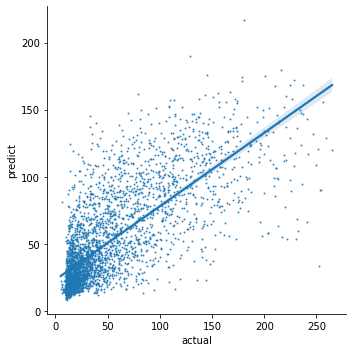

In [25]:
import seaborn as sns

# plot actual vs predicted test agbd values
result = pd.DataFrame( { 'actual' :  y_test.values, 'predict' : best_model.predict( X_test ) } )
sns.lmplot(x='actual',y='predict', data=result, fit_reg=True, scatter_kws={"s": 1 } ) 

In [26]:
# compute r2 between actual and predicted agbd
result[ 'actual' ].corr( result[ 'predict' ] )

0.7467613600412959

In [27]:
print(best_model.best_score_)
print(best_model.best_params_)

-1018.041662612059
{'mlp__colsample_bytree': 0.8, 'mlp__learning_rate': 0.02, 'mlp__max_depth': 10, 'mlp__n_estimators': 600, 'mlp__subsample': 0.6}


<BarContainer object of 41 artists>

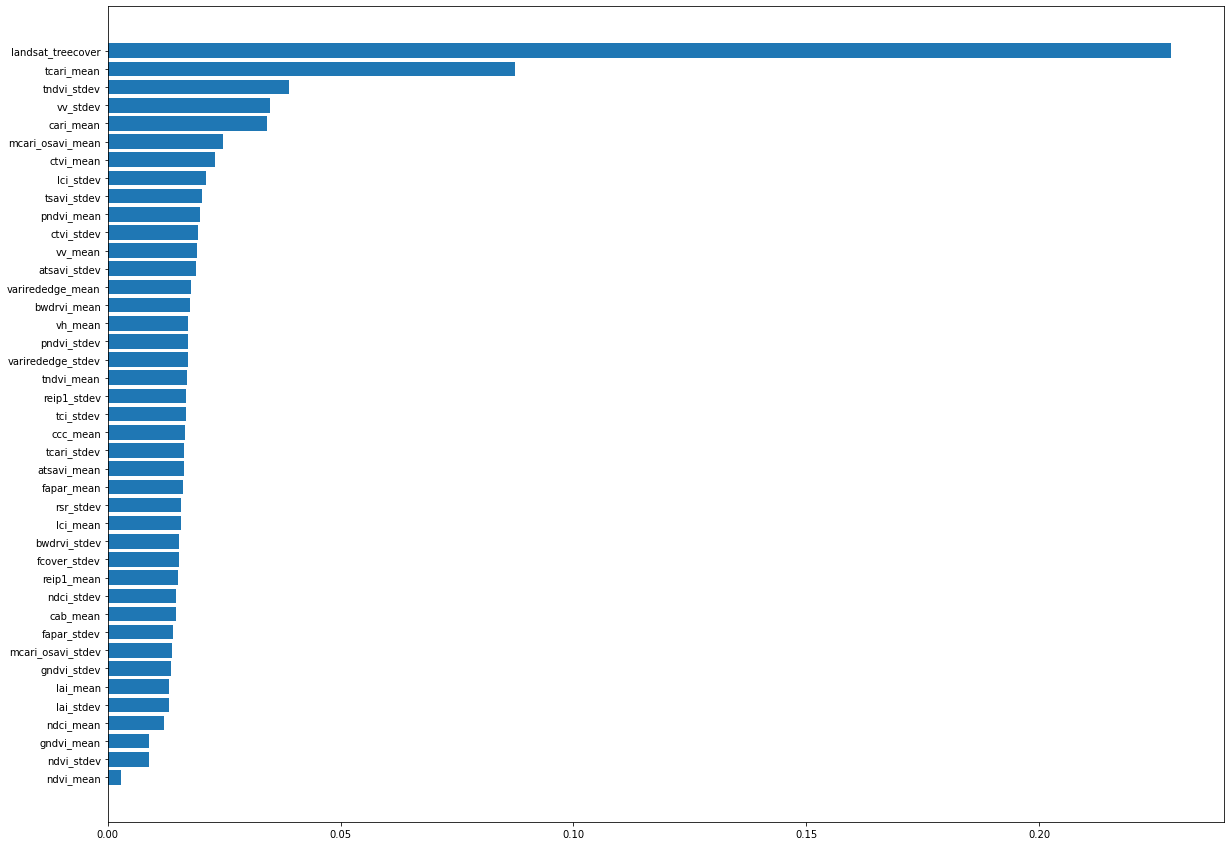

In [28]:
model = best_model.best_estimator_.steps[1][1]
sorted_idx = model.feature_importances_.argsort()

plt.figure( figsize=(20,15) )
plt.barh( best_model.feature_names_in_[sorted_idx], model.feature_importances_[sorted_idx] )